<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/Library_Simplify_ProductionML_1027_%EB%8F%8C%EC%95%84%EA%B0%91%EB%8B%88%EB%8B%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library (close)

## Visualization (Plotting)

## Data Generation

- **Two dataset types**
  1. **K-intensive**
     - $K \sim U(0,1)$
     - $L = 0$
  2. **L-intensive**
     - $K = 0$
     - $L \sim U(0,1)$

- **Three target functions (each with noise)**
  1. $y = K^3 + \epsilon$
  2. $y = -K^3 + \epsilon$
  3. $y = L^3 + \epsilon$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# === 1. Data ===
np.random.seed(42)
tf.random.set_seed(42)

n = 1000
noise_scale = 0.05

# K-intensive: K~U(0,1), L=0
K = np.random.rand(n, 1)
L0 = np.zeros((n, 1))
X_K = np.hstack([K, L0])

# L-intensive: K=0, L~U(0,1)
K0 = np.zeros((n, 1))
L = np.random.rand(n, 1)
X_L = np.hstack([K0, L])

# Targets with noise
y1 = K**3 + np.random.normal(0, noise_scale, size=(n, 1))      # K³ + noise
y2 = -K**3 + np.random.normal(0, noise_scale, size=(n, 1))     # −K³ + noise
y3 = L**3 + np.random.normal(0, noise_scale, size=(n, 1))      # L³ + noise
y4 = -L**3 + np.random.normal(0, noise_scale, size=(n, 1))


## Build & Train Model

### Build Original Model

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Lambda

# Original Model - 5 layer trained on y1
def build_model():
    model = Sequential([
        tf.keras.Input(shape=(2,)),
        Lambda(tf.nn.relu, name="input_relu"),
        Dense(8, activation="relu"),
        Dense(8, activation="relu"),
        Dense(8, activation="relu"),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

model = build_model()
model.fit(X_K, y1, epochs=100, batch_size=32, verbose=0)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_relu (Lambda)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533 (2.09 KB)

 Trainable params: 177 (708.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 356 (1.39 KB)

### OLS vs. ReLU Functions

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

tf.random.set_seed(42)

def run_comparison(X, y, x_scalar, xlabel, title_prefix):
    # train/test split
    X_tr, X_te, y_tr, y_te, x_tr, x_te = train_test_split(
        X, y, x_scalar, test_size=0.3, random_state=42
    )

    g = np.linspace(0, 1, 400).reshape(-1, 1)
    if xlabel == "K":
        X_grid = np.hstack([g, np.zeros_like(g)])
        y_grid_true = g**3
    else:  # L
        X_grid = np.hstack([np.zeros_like(g), g])
        y_grid_true = g**3

    # ---- OLS ----
    ols = LinearRegression()
    ols.fit(X_tr, y_tr)
    y_te_pred_ols = ols.predict(X_te)
    y_grid_pred_ols = ols.predict(X_grid)
    mse_ols = mean_squared_error(y_te, y_te_pred_ols)

    # ---- ReLU NN ----
    nn = build_model()
    nn.fit(X_tr, y_tr, epochs=100, batch_size=32, verbose=0)

    y_te_pred_nn = nn.predict(X_te, verbose=0)
    y_grid_pred_nn = nn.predict(X_grid, verbose=0)
    mse_nn = mean_squared_error(y_te, y_te_pred_nn)

    print(f"[{title_prefix}] Test MSE - OLS: {mse_ols:.6f} | ReLU NN: {mse_nn:.6f}")

    fig = plt.figure(figsize=(12, 8))

    # (True vs OLS vs NN)
    ax1 = plt.subplot(2, 1, 1)
    ax1.scatter(x_tr, y_tr, s=10, alpha=0.35, label="train")
    ax1.plot(g, y_grid_true, lw=2, label="true (noiseless)")
    ax1.plot(g, y_grid_pred_ols, lw=2, linestyle="--", label="OLS")
    ax1.plot(g, y_grid_pred_nn, lw=2, linestyle="-.", label="ReLU NN")
    ax1.set_xlim(0, 1)
    ax1.set_xlabel(xlabel); ax1.set_ylabel("y")
    ax1.set_title(f"[{title_prefix}] Fit comparison (train scatter + curves)")
    ax1.legend(loc="best")

    # OLS vs NN
    res_ols = (y_te - y_te_pred_ols).ravel()
    res_nn  = (y_te - y_te_pred_nn).ravel()
    res_max = np.percentile(np.abs(np.concatenate([res_ols, res_nn])), 99)
    ylim = (-res_max, res_max)

    ax2 = plt.subplot(2, 2, 3)
    ax2.scatter(x_te, res_ols, s=12, alpha=0.7)
    ax2.axhline(0, color="black", lw=1)
    ax2.set_xlim(0, 1); ax2.set_ylim(*ylim)
    ax2.set_xlabel(xlabel); ax2.set_ylabel("Residual (Y−Ŷ)")
    ax2.set_title(f"Residuals (OLS)  MSE={mse_ols:.4f}")

    ax3 = plt.subplot(2, 2, 4)
    ax3.scatter(x_te, res_nn, s=12, alpha=0.7)
    ax3.axhline(0, color="black", lw=1)
    ax3.set_xlim(0, 1); ax3.set_ylim(*ylim)
    ax3.set_xlabel(xlabel); ax3.set_ylabel("Residual (Y−Ŷ)")
    ax3.set_title(f"Residuals (ReLU NN)  MSE={mse_nn:.4f}")

    plt.tight_layout()
    plt.show()

# Run

### OLS vs. ReLU

[K^3 target] Test MSE - OLS: 0.015044 | ReLU NN: 0.002534


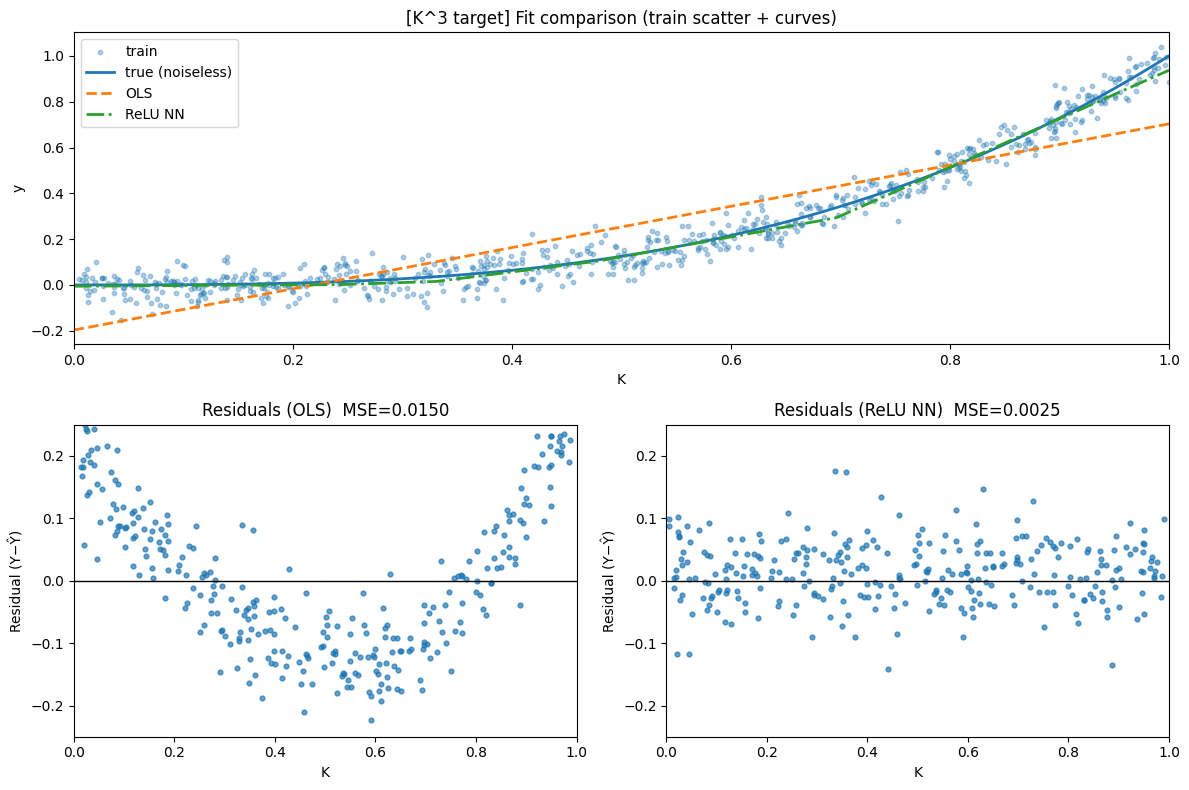

In [8]:
run_comparison(X_K, y1, K, xlabel="K", title_prefix="K^3 target")